TF-IDF 簡介：

有很多不同的數學公式可以用來計算 tf-idf。這邊的例子以上述的數學公式來計算。詞頻（tf）是一詞語出現的次數除以該檔案的總詞語數。假如一篇檔案的總詞語數是100個，而詞語「母牛」出現了3次，那麼「母牛」一詞在該檔案中的詞頻就是3/100=0.03。而計算檔案頻率（IDF）的方法是以檔案集的檔案總數，除以出現「母牛」一詞的檔案數。所以，如果「母牛」一詞在1,000份檔案出現過，而檔案總數是10,000,000份的話，其逆向檔案頻率就是lg（10,000,000 / 1,000）=4。最後的 tf-idf 的分數為0.03 * 4=0.12。

Chatgpt Prompt：

你現在模擬一個文本(10列文字，一半內容正向，一半內容負向

我要先用 tf-idf 做關鍵字提取以及分數計算，並把提取的關鍵字進行詞頻統計（文字雲）與 tf-idf 分數結果視覺化（雷達圖）

再來，請想辦法幫我做成表格資料，欄位你想想可以有甚麼（表格數據是為了rnn 的分類建模）

# Load data

In [ ]:
import pandas as pd

df1 = pd.read_csv('/content/drive/MyDrive/人工智慧實務專題/正式專案/爬蟲/scam_records_1.csv', delimiter=",")
df1 = df1["Content"]
# print(df1.head())

df2 = pd.read_csv('/content/drive/MyDrive/人工智慧實務專題/正式專案/爬蟲/scam_records_2.csv', delimiter=",")
df2 = df2["Content"]
# print(df2.head())

df3 = pd.read_csv('/content/drive/MyDrive/人工智慧實務專題/正式專案/爬蟲/scam_records_3.csv', delimiter=",")
df3 = df3["texts"]
# print(df3.head())

df4 = pd.read_csv('/content/drive/MyDrive/人工智慧實務專題/正式專案/爬蟲/scam_records_4.csv', delimiter=",")
df4 = df4["content"]
# print(df4.head())

df5 = pd.read_csv('/content/drive/MyDrive/人工智慧實務專題/正式專案/爬蟲/scam_records_5.csv', delimiter=",", encoding="ISO-8859-1")
df5 = df5.iloc[:, 0]
# print(df5.head())

# concatenate all dataset
df = pd.concat([df1, df2, df3, df4, df5], ignore_index=True)
print(df.head())
print(df.shape)

texts = df
# filter float
texts = [text for text in texts if not isinstance(text, float)]

0    My favorite is the “Grandma I’m in trouble cal...
1    I might be a little biased, but as an Asana em...
2    I had the “I’m calling to fix your Windows” ca...
3    One time, I was hanging out at my grandmother’...
4    A young woman, perhaps in her early twenties b...
dtype: object
(1038,)


# Natural language processing

## Keyword extraction: part-of-speech tagging & selection

In [ ]:
import re

import nltk
nltk.download("stopwords")
nltk.download('averaged_perceptron_tagger')

from nltk.corpus import stopwords
from nltk import pos_tag

# create an empty list to store the modified texts
corpus = []
for i in range(0, len(texts)):
  review = re.sub("[^a-zA-Z]", " ", texts[i]) # replace all punctuations with space
  review = review.lower() # turn all words into lowercase ones
  review = review.split()
  tagged_review = pos_tag(review)

  all_stopwords = stopwords.words("english")
  # add redundancy words
  new_stopwords = ["call", "scammer", "phone", "time", "name", "year", "caller",
                    "scam", "day", "guy", "hello", "minutes", "windows", "accent", "someone", "voice",
                    "person", "people", "question", "thing", "car", "calls", "conversation", "scammers",
                    "years", "something", "work", "telephone", "man", "home", "house", "line", "rings",
                    "point", "friend", "office", "yes", "sir", "lot", "couple", "questions", "way", "months",
                    "bit", "fun", "things", "end", "today", "computer", "company", "life", "woman", "okay",
                    "days", "lady", "anything", "sorry", "morning", "times", "india", "one", "hi", "fraud",
                    "kind", "night", "department", "nothing", "job", "cell", "rang", "friends", "everything",
                    "hours", "month", "list", "weeks", "story", "answer", "part", "hour", "moment", "etc",
                    "team", "family", "week", "state", "number", "please", "numbers", "yeah", "right", "thank"]
  all_stopwords.extend(new_stopwords)

  review = [word for word, pos in tagged_review if pos.startswith("NN") and word not in set(all_stopwords)] # remove stopwords and keep meaningful noun roots
  review = " ".join(review) # turn each word lists into full strings(in one list)
  corpus.append(review)
print(corpus)
print(len(corpus))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


['favorite grandma trouble spouse children grandchild grandma course grandson grandma honey trouble church police officer grandpa marijuana possession intent', 'employee asana project management tool source truth tasks goals priorities challenges stride clarity coordination collaboration', 'dumb rock course crack goodness living room window rain problem birds', 'grandmother grandkids brother grandma id speakerphone hey help york money twenties', 'twenties sound activity servers sticker brand shack make calculator someplace', 'photos nobody photos photos texts springs price track process burner credit card address g', 'co worker window', 'warranty associate support ass ms mazza mazzer warranty hyundai heaven warranty miles', 'support bobson support virus activity device device support reports support front device glad support start button', 'customer service account credit card husband dig card meantime suspicions b', 'thailand sales callers teaching assignment air coffee shop floor lob

## Vectorizing corpus

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words=all_stopwords)

# convert texts to TF-IDF features
tfidf_features = tfidf_vectorizer.fit_transform(corpus)

# get the vocabulary and corresponding index
vocabulary = tfidf_vectorizer.get_feature_names_out()

# calculate the average TF-IDF score of each word
tfidf_mean = tfidf_features.toarray().mean(axis=0)

# Word frequency counting: show first 50 keywords

In [ ]:
from collections import Counter

# calculate word frequency(decending sorted)
word_counter = Counter(" ".join(corpus).split())

# choose the number of keywords to display
num_top_words = 50
top_words = [word for word, _ in word_counter.most_common(num_top_words)]
top_frequencies = [word_counter[word] for word in top_words]

for word, freq in zip(top_words, top_frequencies):
    print(f"{word}: {freq}")

money: 120
account: 103
card: 84
security: 79
credit: 61
problem: 58
support: 51
bank: 47
virus: 45
address: 43
information: 43
service: 42
details: 42
police: 41
insurance: 35
son: 35
wife: 34
access: 31
accident: 30
click: 30
husband: 29
system: 28
device: 27
internet: 26
help: 25
irs: 25
mother: 23
message: 23
telemarketer: 23
course: 22
activity: 22
email: 22
offer: 22
taxes: 21
bill: 21
id: 20
dollars: 20
dad: 19
site: 19
children: 18
gift: 18
arrest: 18
government: 18
subscription: 18
sales: 17
software: 17
order: 17
desk: 17
warrant: 17
program: 16


# Word frequency counting: bar chart

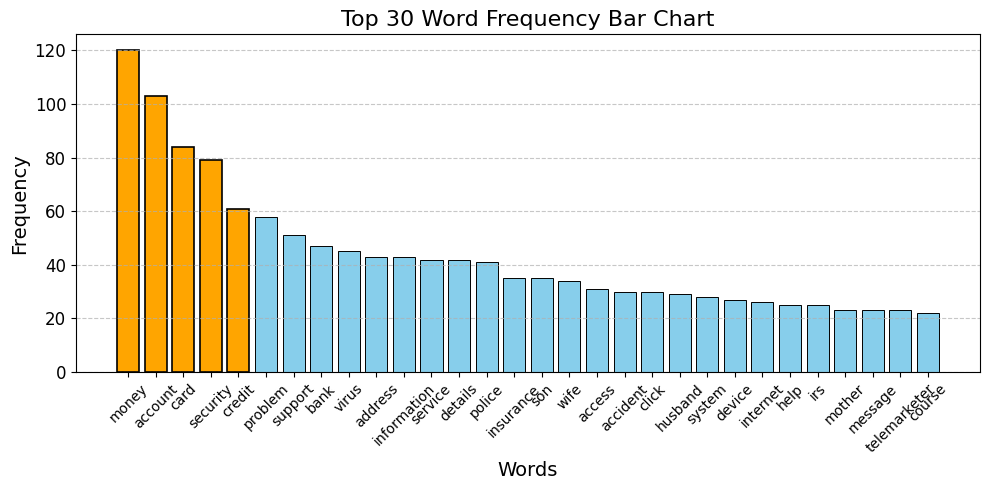

In [ ]:
import matplotlib.pyplot as plt

# choose the number of keywords to display
num_top_words = 30
top_words = [word for word, _ in word_counter.most_common(num_top_words)]
top_frequencies = [word_counter[word] for word in top_words]

plt.figure(figsize=(10, 5))
bars = plt.bar(top_words, top_frequencies, color="skyblue", edgecolor="black", linewidth=0.7)
# Highlight the top 5 keywords
for bar in bars[:5]:
    bar.set_color("orange")
    bar.set_edgecolor("black")
    bar.set_linewidth(1.2)

plt.title("Top {} Word Frequency Bar Chart".format(num_top_words), fontsize=16)
plt.xlabel("Words", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# Word frequency counting: word cloud

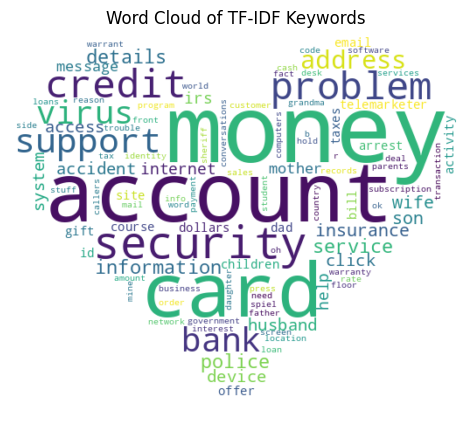

In [ ]:
from wordcloud import WordCloud
from PIL import Image
import numpy as np

# generate word cloud
mask = np.array(Image.open("/content/drive/MyDrive/人工智慧實務專題/正式專案/NLP/heart.png"))
wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="viridis", max_words=100, mask=mask)
wordcloud.generate_from_frequencies(frequencies=word_counter)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title("Word Cloud of TF-IDF Keywords")
plt.axis("off")
plt.show()

# TF-IDF score calculating

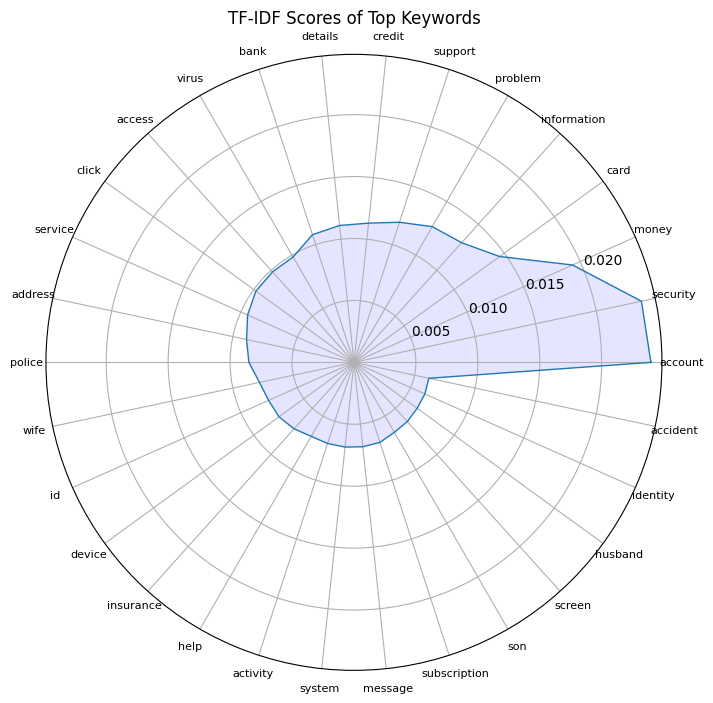

In [ ]:
import numpy as np

# choose the number of keywords to display
num_top_keywords = 30
top_indices = np.argsort(tfidf_mean)[::-1][:num_top_keywords] # return index array sorted from high to low by TF-IDF score
top_keywords = np.array(vocabulary)[top_indices]
top_scores = tfidf_mean[top_indices]

# set the angle, number of categories and category names of the radar chart
angles = np.linspace(0, 2 * np.pi, num_top_keywords, endpoint=False).tolist()
values = top_scores.tolist()
values += values[:1]
angles += angles[:1]

plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)
plt.xticks(angles[:-1], top_keywords, color="black", size=8)
ax.plot(angles, values, linewidth=1, linestyle="solid")
ax.fill(angles, values, "b", alpha=0.1)
plt.title("TF-IDF Scores of Top Keywords")
plt.show()

# Create table to show scores

In [ ]:
import pandas as pd

df = pd.DataFrame(top_scores, index=top_keywords, columns=['TF-IDF Mean Score'])
print(df)

              TF-IDF Mean Score
account                0.023978
security               0.023732
money                  0.019324
card                   0.014538
information            0.012995
problem                0.012651
support                0.011892
credit                 0.011303
details                0.011110
bank                   0.010837
virus                  0.009826
access                 0.009826
click                  0.009785
service                0.009398
address                0.008865
police                 0.008484
wife                   0.007795
id                     0.007543
device                 0.007481
insurance              0.007225
help                   0.006900
activity               0.006886
system                 0.006878
message                0.006851
subscription           0.006796
son                    0.006524
screen                 0.006439
husband                0.006311
identity               0.006269
accident               0.006185
